# Parsing CME Data Files

CME data files come to us in the FIX 5.0 SP2 format.  They are compressed files (in the gzip format) consisting of many lines.  Each line is a set of field value pairs, separated by ASCII 0x01.  Each field pair is a field number and a field value separated by an = sign.

To keep the demo code running fast, we work with a random subsample consisting of one line per ten thousand.

In [1]:
tiny_subsample_file = "/Users/brian/SkyDrive/data/HF/subsamples/XCME_MD_ES_20141013_20141017"
with open(tiny_subsample_file,"rt") as ssfile:
    data_lines = [line.strip() for line in ssfile]
sample_line = data_lines[-1]
print("{ln!r}".format(ln=sample_line))

'1128=9\x019=265\x0135=X\x0149=CME\x0134=10065111\x0152=20141013152659076\x0175=20141013\x01268=2\x01279=2\x0122=8\x0148=656784\x0183=215750\x01107=ESV4 C1895\x01269=1\x01270=1775\x01271=5\x01273=152659000\x01336=2\x01346=1\x011023=1\x01279=0\x0122=8\x0148=656784\x0183=215751\x01107=ESV4 C1895\x01269=1\x01270=1850\x01271=291\x01273=152659000\x01336=2\x01346=6\x011023=3\x0110=008\x01'


There exist open-source engines for parsing these files (such as [QuickFix](http://quickfixengine.org/quickfix/doc/html/)) but we can also do some simple parsing ourselves

In [2]:
field_values = [f.split("=") for f in sample_line.split("\x01")]
for fv in field_values[:5]:
    print("{field_num}: {field_value}".format(field_num=fv[0],
                                              field_value=fv[1]))

1128: 9
9: 265
35: X
49: CME
34: 10065111


We can see what these field numbers mean by checking the official FIX spec, or more conveniently on [FIXimate](http://www.fixtradingcommunity.org/FIXimate/FIXimate3.0/)

In [3]:
useful_info_fields = {
    '107': 'SecurityDesc',
    '268': 'NoMDEntries', # number of entries
    '269': 'MDEntryType', # 0=Bid, 1=Offer, 2=Trade
    '270': 'MDEntryPx', # Price
    '279': 'MDUpdateAction', 
    '35': 'MsgType',
    '48': 'SecurityID',
    '52': 'SendingTime',
    '75': 'TradeDate',
    # The following are trickier to parse due to repeating according to entry types
    #'1020': 'TradeVolume',
    #'1023': 'MDPriceLevel',
    #'271': 'MDEntrySize', 
    #'277': 'TradeCondition', 
}

Parsing FIX messages is tricky, because not every field has to be in every message, and because messages may comprise information for several market updates at once.  We can make an ugly and poor-performing parser as below.  Equivalents in R might do well to use the _hash_ package.

Otherwise, we can make a better-performing one using [Rcpp](http://www.rcpp.org) for R, or [Weave](http://wiki.scipy.org/Weave) or [CFFI](http://python-cffi.org) for Python.

In [4]:
def check_equal(iterator):
    try:
        iterator = iter(iterator)
        first = next(iterator)
        return all(first == rest for rest in iterator)
    except StopIteration:
        return True
def fields_in(line):
    """
    Parse a FIX message line into a list of dicts, each 
     one representing a market data update
    """
    f = {}
    group_count = None
    observed_group_count = 1
    field_values = [f.split("=") for f in line.split("\x01") if f]
    # Unused, but parse the official mkt update count
    for field,field_value in field_values:
        if field=='268':
            group_count = int(field_value)
    # Record field values
    for field,field_value in field_values:
        if field in useful_info_fields:
            info_field = useful_info_fields[field]
            if info_field in f:
                if isinstance(f[info_field],list):
                    # This field has already been given to us more than once.  Append to the list.
                    f[info_field].append(field_value)
                else:
                    # We have seen this field before and now are seeing it a second time.  Turn it into
                    #  a list
                    existing = f[info_field]
                    f[info_field] = [existing, field_value]
            else:
                # We never saw this field before.  Record its value.
                f[info_field] = field_value
    # Find out how many market updates this message contained
    for field,field_value in f.items():
        if isinstance(field_value,list):
            if check_equal(field_value):
                # Don't bother with cases where all updates had the same value
                f[field] = field_value[0]
            else:
                # Differing values in updates.  Count them.
                num_this_group = len(field_value)
                # Safety check
                if observed_group_count>1 and num_this_group!=observed_group_count:
                    print("Surprise got %d not %d from %s=%s\n%s\n%s\n-------------------------"%(
                            num_this_group,observed_group_count,field,field_value,
                            ' | '.join(line.split("\x01")),
                            ' | '.join(sorted(line.split("\x01"))),
                        ))
                else:
                    observed_group_count = max(observed_group_count,num_this_group)
    # Safety checks
    for field,field_value in f.items():
        if isinstance(field_value,list) and len(field_value)!=observed_group_count:
            print("Error: saw %d values for %s but observed_group_count was %s\n%s"%(
                len(field_value),field,observed_group_count,sorted(field_values) ))
    # Create list of market updates from message field lists
    if group_count and group_count>1:
        gf = [f.copy() for i in range(group_count)]
        for field,field_value in f.items():
            if isinstance(field_value,list):
                for j in range(group_count):
                    gf[j][field] = field_value[j]
    else:
        gf = [f]
    return gf
fields_in(sample_line)

[{'MDEntryPx': '1775',
  'MDEntryType': '1',
  'MDUpdateAction': '2',
  'MsgType': 'X',
  'NoMDEntries': '2',
  'SecurityDesc': 'ESV4 C1895',
  'SecurityID': '656784',
  'SendingTime': '20141013152659076',
  'TradeDate': '20141013'},
 {'MDEntryPx': '1850',
  'MDEntryType': '1',
  'MDUpdateAction': '0',
  'MsgType': 'X',
  'NoMDEntries': '2',
  'SecurityDesc': 'ESV4 C1895',
  'SecurityID': '656784',
  'SendingTime': '20141013152659076',
  'TradeDate': '20141013'}]

Let's see what securities are priced in this file

In [5]:
import collections
securities = collections.defaultdict(int)
dict_lines = sum([fields_in(line) for line in data_lines],[])
for d in dict_lines:
    securities[(d['SecurityDesc'], d['SecurityID'])] += 1
sorted([(v,' - '.join(k)) for k,v in securities.items()])[-11:]

[(19, 'ESX4 P1865 - 543577'),
 (19, 'ESZ4 P1895 - 284860'),
 (20, 'ESV4 C1935 - 690557'),
 (21, 'ESV4 P1820 - 638458'),
 (23, 'ESV4 C1930 - 494457'),
 (23, 'ESV4 P1825 - 423660'),
 (25, 'ESV4 P1815 - 285361'),
 (27, 'ESM5 - 85974'),
 (28, 'ESV4 P1885 - 284903'),
 (107, 'ESH5 - 50393'),
 (1349, 'ESZ4 - 28095')]

Timestamps are given in YYYYmmDDHHMMSSooo up to millisecond precision

In [6]:
import datetime 
def parse_timestamp(s):
    dt_args = [int(x) for x in (s[:4],s[4:6],s[6:8],s[8:10],s[10:12],s[12:14],s[14:])]
    dt_args[-1] *= 1000
    return datetime.datetime(*tuple(dt_args))
parse_timestamp('20150101030405678')

datetime.datetime(2015, 1, 1, 3, 4, 5, 678000)

### Extract And Plot Trade Price

In [7]:
import pandas as pd
december_contract_trade_prices_list = []
for line in data_lines:
    fields_list = fields_in(line)
    for fields in fields_list:
        if 'ESZ4'==fields.get('SecurityDesc') and '2'==fields.get('MDEntryType'):
            price_observed = 0.01*float(fields['MDEntryPx'])
            t = parse_timestamp(fields['SendingTime'])
            december_contract_trade_prices_list.append((t,price_observed))
december_contract_trade_prices_frame = pd.DataFrame(december_contract_trade_prices_list,
                                              columns=("Timestamp","Trade"))
december_contract_trade_prices_frame.set_index(["Timestamp"], inplace=True)
december_contract_trade_prices = december_contract_trade_prices_frame["Trade"]
december_contract_trade_prices_frame

,Trade
Timestamp,
2014-10-12 22:10:03.456000,1884.25
2014-10-13 00:45:55.711000,1885.50
2014-10-13 07:41:55.577000,1887.25
2014-10-13 07:41:55.577000,1887.25
2014-10-13 13:20:56.848000,1898.00
2014-10-13 13:20:56.848000,1898.00
2014-10-13 13:27:23.509000,1898.75
2014-10-13 13:54:57.579000,1894.25
2014-10-13 14:01:07.445000,1897.25


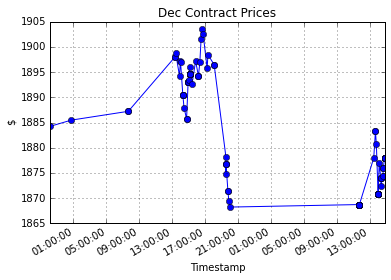

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
december_contract_trade_prices.plot(marker='o', title="Dec Contract Prices")
lab = plt.ylabel("$")

### Full-Density Data

We can load data from a denser file (but have to be careful with memory and CPU time).  To avoid running out of memory, we stream the file and record data only from those lines that are relevant to us.

If we are careful we can also use _gzcat_ and _fgrep_ to cut down our file to mostly relevant lines before processing it in code.  For example

```
gzcat _big_file_ | fgrep 48=28095 | fgrep 269=2 > _smaller_file_
```

In [9]:
import gzip
def get_dense(desc,subsample_file):
    dense_trade_prices_list = []
    N = 0
    with gzip.open(subsample_file,"rt") as ssfile:
        for line in ssfile:
            fields_list = fields_in(line.strip())
            for fields in fields_list:
                if desc==fields.get('SecurityDesc') and '2'==fields.get('MDEntryType'):
                    price_observed = 0.01*float(fields['MDEntryPx'])
                    t = parse_timestamp(fields['SendingTime'])
                    dense_trade_prices_list.append((t,price_observed))
                    N += 1
    print("Found %d"%N)
    return dense_trade_prices_list

In [10]:
def get_dense_frame(desc,subsample_file):
    dense_list = get_dense(desc,subsample_file)
    dense_frame = pd.DataFrame(dense_list,
                                    columns=("Timestamp","Trade"))
    dense_frame.set_index(["Timestamp"], inplace=True)
    dense_prices = dense_frame["Trade"]
    return dense_prices

Now we can plot the futures trades over this period of time

In [11]:
big_subsample_file = "/Users/brian/SkyDrive/data/HF/subsamples/Dense_Emini_Trades.gz"
dense_trade_prices = get_dense_frame(desc='ESZ4',
                                     subsample_file=big_subsample_file)


Found 1422524


2014-10-12 22:00:00.069000
2014-10-14 14:56:19.861000


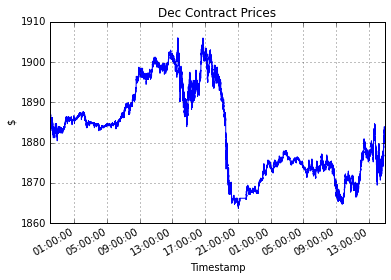

In [12]:
print(dense_trade_prices.index[0])
print(dense_trade_prices.index[-1])
dense_trade_prices.describe()
dense_trade_prices.plot(title="Dec Contract Prices")
lab = plt.ylabel("$")

We see more market microstructure when we zoom in

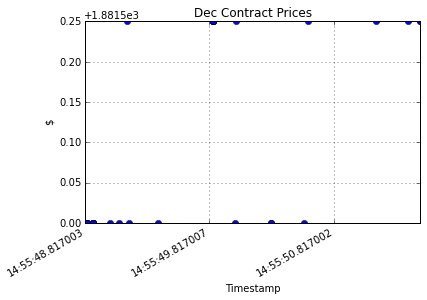

In [13]:
dense_trade_prices.iloc[-1000:-950].plot(title="Dec Contract Prices", 
                                         style='o')
lab = plt.ylabel("$")

There are not as many option trades, so it is reasonable to plot all of them for the entire month

In [14]:
opt_subsample_file = "/Users/brian/SkyDrive/data/HF/subsamples/All_Dense_Emini_C1890_Trades.gz"
dense_opt_prices = get_dense_frame(desc='ESX4 C1890',
                                     subsample_file=opt_subsample_file)
dense_opt_prices.shape

Found 171


(171,)

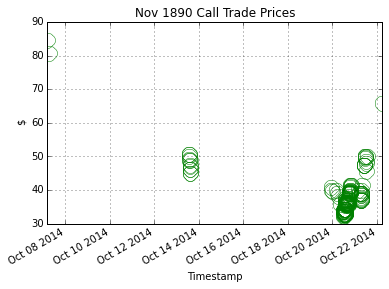

In [15]:
dense_opt_prices.plot(title="Nov 1890 Call Trade Prices", 
                      style="o", 
                      markerfacecolor='none', markeredgecolor='green',
                     markersize=15)
lab = plt.ylabel("$")

Highest-volume Nov option contracts in our tiny subsample

In [16]:
sorted([(v,' - '.join(k)) for k,v in securities.items() if k[0].startswith('ESX4')])[-11:]

[(13, 'ESX4 P1805 - 248672'),
 (13, 'ESX4 P1875 - 735682'),
 (14, 'ESX4 C1890 - 364443'),
 (14, 'ESX4 P1815 - 15681'),
 (15, 'ESX4 C1900 - 433070'),
 (15, 'ESX4 C1920 - 517370'),
 (15, 'ESX4 C1925 - 158578'),
 (17, 'ESX4 P1850 - 330939'),
 (19, 'ESX4 C1905 - 661381'),
 (19, 'ESX4 P1860 - 91071'),
 (19, 'ESX4 P1865 - 543577')]

In [18]:
dense_opt_prices = get_dense_frame(desc='ESX4 P1865',
                                     subsample_file="/tmp/TradeP1865.gz")

Found 259


In [19]:
dense_opt_prices

Timestamp
2014-09-29 08:55:06.185000    16.00
2014-09-29 09:10:09.976000    16.00
2014-09-29 12:52:40.279000    18.00
2014-09-29 18:05:13.096000    16.00
2014-09-30 10:25:34.301000    14.25
2014-09-30 10:33:58.030000    14.25
2014-09-30 13:45:39.363000    16.25
2014-10-06 12:30:10.234000    11.50
2014-10-06 12:32:14.801000    11.50
2014-10-06 14:06:27.884000    11.50
2014-10-06 14:45:37.271000    12.00
2014-10-06 14:45:37.271000    12.00
2014-10-06 14:50:58.112000    13.00
2014-10-06 15:55:45.609000    15.25
2014-10-06 15:55:47.752000    15.25
2014-10-06 15:55:50.293000    15.25
2014-10-06 16:00:24.929000    15.00
2014-10-07 13:05:41.315000    15.50
2014-10-07 13:31:46.949000    17.50
2014-10-07 13:48:17.631000    18.50
2014-10-07 15:35:36.041000    18.50
2014-10-07 15:35:36.042000    18.50
2014-10-07 15:35:36.042000    18.50
2014-10-07 15:35:36.042000    18.50
2014-10-07 15:35:36.042000    18.50
2014-10-07 15:35:37.201000    18.50
2014-10-07 15:35:37.201000    18.50
2014-10-07 15:35:3